In [11]:
import pandas as pd
import os
import pickle
from preprocess import *
from soplata import *
from utils import *
import pickle

# read assessment data
with open('../Assessment/assessment.dat') as f:
    assessment = pickle.load(f)
f.close()
subjects = assessment['ID']

# read location and reason data
data_dir = 'features_breakloc/'

times = []
reasons = []
locations = []
durations = []
accomplishments = []
pleasures = []
ind_toremove = []
for (i,subject) in enumerate(subjects):
    print i,
    filename = data_dir+subject+'.dat'
    if os.path.exists(filename):
        
        with open(filename) as f:
            feature, target = pickle.load(f)
        f.close()
        
        times.append(list(feature['midtime']))
        reasons.append(list(target['reason']))
        locations.append(list(target['location']))
        durations.append(np.array(feature['duration']))
        accomplishments.append(np.array(target['accomplishment']))
        pleasures.append(np.array(target['pleasure']))
    else:
        ind_toremove.append(i)
        print 'subject {} skipped because no data.'.format(subject)

# remove assessments of subject which don't exist in sensor feature data
assessment = assessment.drop(ind_toremove, axis=0)
assessment = assessment.reset_index(drop=True)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 subject 1367477 skipped because no data.
107 108 109 110 111 112 113 114 115 116 117 118 119 120 subject 1422927 skipped because no data.
121 122 123 124 125 126 127 128 129 130 subject 1496251 skipped because no data.
131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 subject BE623WB skipped because no data.
162 163 164 165 166 167 168 subject FI330WL skipped because no data.
169 170 171 subject FP410BI skipped because no data.
172 173 174 175 176 177 178 179 180 181 subject LR112KQ skipped because no data.
182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205

In [2]:
# finding location frequencies across subjects

with open('top_locations.dat') as f:
    loc_top = pickle.load(f)
f.close()

loc_top_dur = ['DUR '+lt for lt in loc_top]

loc_freq = pd.DataFrame(index=range(len(locations)),columns=loc_top)
loc_dur = pd.DataFrame(index=range(len(locations)),columns=loc_top_dur)
for (i,loc_subject) in enumerate(locations):
    for (j,loc_t) in enumerate(loc_top):
#         if loc_t in loc_subject:
        loc_freq.loc[i,loc_t] = loc_subject.count(loc_t)/float(len(loc_subject))
        loc_dur.loc[i,loc_top_dur[j]] = np.mean(durations[i][np.array(loc_subject)==loc_t])

loc_top

/usr/local/lib/python2.7/dist-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


['Shop or Store',
 'Home',
 'Food (Restaurant, Cafe)',
 "Another's Home",
 'Professional or Medical Office',
 'Work',
 'Arts & Entertainment (Theater, Music Venue, Etc.)',
 'Outdoors & Recreation',
 'Spiritual (Church, Temple, Etc.)',
 'Nightlife Spot (Bar, Club)']

In [3]:
# finding reason frequencies across subjects

with open('top_reasons.dat') as f:
    reason_top = pickle.load(f)
f.close()

reason_top_dur = ['DUR '+rt for rt in reason_top]

reason_freq = pd.DataFrame(index=range(len(reasons)),columns=reason_top)
reason_dur = pd.DataFrame(index=range(len(reasons)),columns=reason_top_dur)
for (i,reason_subject) in enumerate(reasons):
    for (j,reason_t) in enumerate(reason_top):
#         if reason_t in reason_subject:
        reason_freq.loc[i,reason_t] = reason_subject.count(reason_t)/float(len(reason_subject))
        reason_dur.loc[i,reason_top_dur[j]] = np.mean(durations[i][np.array(reason_subject)==reason_t])



In [4]:
# accomplishment and pleasure means and vars

accomp_all = pd.DataFrame(index=range(len(locations)),columns=['total accomp mean','total accomp var'])
for (i,acc) in enumerate(accomplishments):
    accomp_all.loc[i,'total accomp mean'] = np.nanmean(acc)
    accomp_all.loc[i,'total accomp var'] = np.nanvar(acc)

pleas_all = pd.DataFrame(index=range(len(locations)),columns=['total pleasure mean','total pleasure var'])
for (i,pl) in enumerate(pleasures):
    pleas_all.loc[i,'total pleasure mean'] = np.nanmean(pl)
    pleas_all.loc[i,'total pleasure var'] = np.nanvar(pl)

In [5]:
# accomplishment and pleasure per location

accomp_mean = pd.DataFrame(index=range(len(locations)),columns=['acc m '+lt for lt in loc_top])
pleas_mean = pd.DataFrame(index=range(len(locations)),columns=['pls m '+lt for lt in loc_top])
for (i,_) in enumerate(accomplishments):
    for (j,l_top) in enumerate(loc_top):
        inds = np.where(np.array(locations[i])==l_top)[0]
        accomp_mean.loc[i,'acc m '+l_top] = np.nanmean(accomplishments[i][inds])
        pleas_mean.loc[i,'pls m '+l_top] = np.nanmean(pleasures[i][inds])

/usr/local/lib/python2.7/dist-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


In [6]:
def estimate_entropy(loc, n):
    loc_uniq = np.unique(loc)
    loc_uniq_freq = [loc.count(l) for l in loc_uniq]
    loc_uniq_freq = np.sort(loc_uniq_freq)
    loc_uniq_freq = loc_uniq_freq[loc_uniq_freq.size-n:]
    loc_uniq_freq = loc_uniq_freq/np.sum(loc_uniq_freq).astype(float)
    ent = 0
    for (_,lf) in enumerate(loc_uniq_freq):
        ent += -lf*np.log(lf)
    return ent, ent/np.log(loc_uniq_freq.size)

In [83]:
def estimate_circadian(loc, time, period, n):
    time = np.mod(time, period)/float(period)
    loc_uniq, counts = np.unique(loc, return_counts=True)
    ind_sort = np.argsort(-counts)
    loc_uniq = loc_uniq[ind_sort]
    energy = np.ones(n)*np.nan
    for i in range(min(n,loc_uniq.size)):
        ind = np.where(np.array(loc)==loc_uniq[i])[0]
        t = time[ind]
        energy[i] = np.nansum(np.cos(2*np.pi*t))**2 + np.nansum(np.sin(2*np.pi*t))**2
        energy[i] = energy[i]/(t.size**2)
    return energy

In [123]:
def estimate_change(loc):
    change = 0
    for j in range(len(loc)-1):
        if loc[j]!=loc[j+1]:
            change += 1
    change = change/float(len(loc)-1)
    return change

In [124]:
entropy = pd.DataFrame(index=range(len(locations)))
cm = pd.DataFrame(index=range(len(locations)))
change = pd.DataFrame(index=range(len(locations)))
for i in range(len(locations)):
    for j in np.arange(2,10):
        ent, entn = estimate_entropy(locations[i],j)
        entropy.loc[i,'entropy {}'.format(j)] = ent
        entropy.loc[i,'entropy {} norm'.format(j)] = entn
    
    c = estimate_circadian(locations[i], times[i], 86400, 10)
    for j in range(c.size):
        cm.loc[i,'circadian {}'.format(j)] = c[j]
    cm.loc[i,'circadian mean'] = np.nanmean(c)
    
    change.loc[i,'change'] = estimate_change(locations[i])

<IPython.core.display.Javascript object>


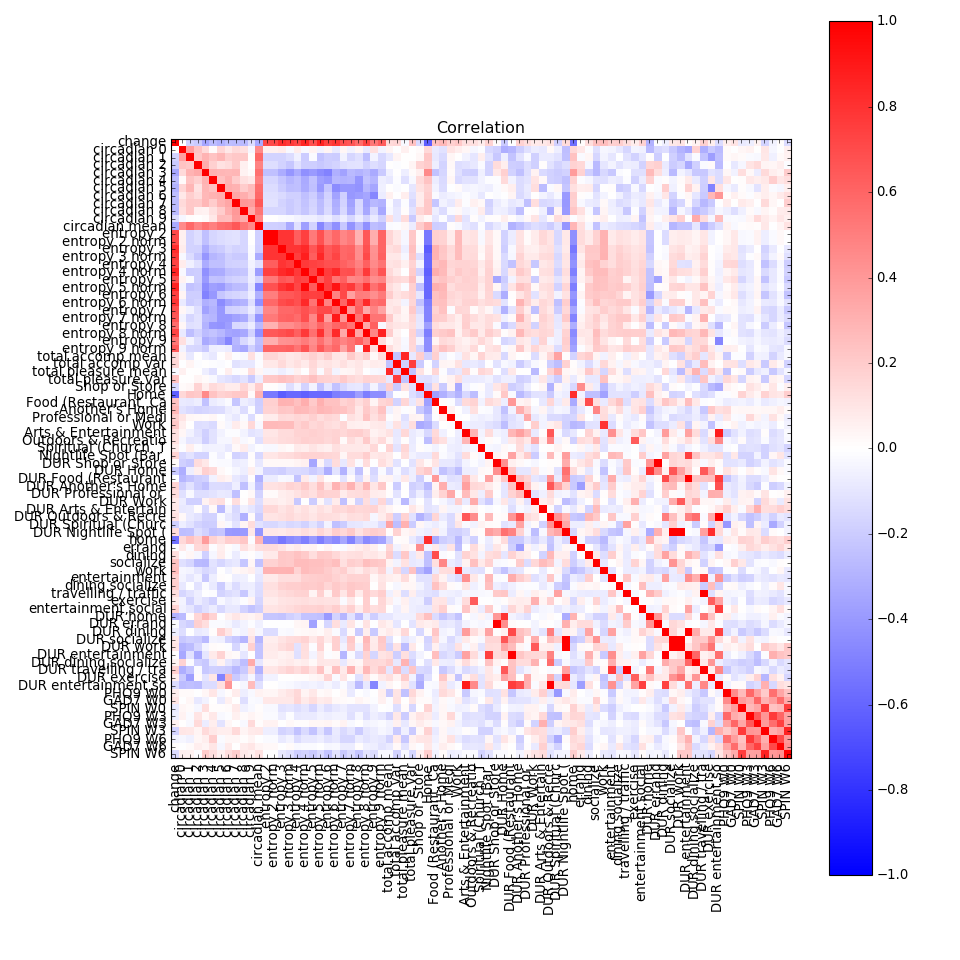

In [125]:
# correlation matrix
save_data = True

data_fm = pd.concat([change, cm, entropy, accomp_all, pleas_all, loc_freq, loc_dur, reason_freq, reason_dur,\
                     assessment.drop(['ID'],axis=1)], axis=1)

data_cov = calculate_covariance(data_fm.values.astype(float))

#%matplotlib inline
%matplotlib notebook

# truncate labels
labs = [lab[0:20] for lab in data_fm.columns]

plot_confusion_matrix(data_cov, labels=labs, cmap=plt.cm.bwr, xsize=12, ysize=12)

if save_data:
    with open('location_assessment.dat','w') as f:
        pickle.dump(data_fm, f)
    f.close()

In [4]:
import numpy as np
np.mod(10,4)

2